In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import os

exec(open("../header.py").read())

Header initialized


In [2]:
raw_train_data = pd.read_csv(processed_root("03-bag-of-words/bow_train_data.csv"))
raw_val_data = pd.read_csv(processed_root("03-bag-of-words/bow_val_data.csv"))
raw_test_data = pd.read_csv(processed_root("03-bag-of-words/bow_test_data.csv"))

In [5]:
raw_train_data['poetry_text'].values[0]

'(excerpt)\n"Throughout these infinite orbs of mingling light,\nOf which yon earth is one, is wide diffus\'d\nA Spirit of activity and life,\nThat knows no term, cessation, or decay;\nThat fades not when the lamp of earthly life,\nExtinguish\'d in the dampness of the grave,\nAwhile there slumbers, more than when the babe\nIn the dim newness of its being feels\nThe impulses of sublunary things,\nAnd all is wonder to unpractis\'d sense:\nBut, active, steadfast and eternal, still\nGuides the fierce whirlwind, in the tempest roars,\nCheers in the day, breathes in the balmy groves,\nStrengthens in health, and poisons in disease;\nAnd in the storm of change, that ceaselessly\nRolls round the eternal universe and shakes\nIts undecaying battlement, presides,\nApportioning with irresistible law\nThe place each spring of its machine shall fill;\nSo that when waves on waves tumultuous heap\nConfusion to the clouds, and fiercely driven\nHeaven\'s lightnings scorch the uprooted ocean-fords,\nWhilst

### Feature Engineering

Average word length, average words per line, average syllables per line, rhyme (different rhyme schemes, or number of rhymes etc.), genre (nature, love, etc., use embedding space to find out how close the poems are to each genre) 

In [56]:
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import enchant
import re

In [57]:
# intializing checkeres
d = enchant.Dict("en_US")
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [121]:
def word_suggestions(w):
    if d.check(w) == False:
        sugggestions = d.suggest(w)
        if len(sugggestions) > 0:
            w = d.suggest(w)[0]
    return w

In [144]:
def str_cleanup(s):
    """given a line of a poem, get rid of punctuation, all lowercase, etc"""
    # all lower case
    s = s.lower()
    # first split into words
    s = s.split(" ") 
    # get rid of punctuation
    s = list(map(lambda x: re.sub("[.,-/\"'();:{}=!?%^&*]","",x), s))
    # getting rid of empty string
    while '' in s:
        s.remove('') 
    # spell checks
    s = list(map(word_suggestions, s))
    return s

In [145]:
first_poem = raw_train_data['poetry_text'].values[0]
first_poem = first_poem.split("\n")

#### Average word length

In [141]:
def ave_word_len(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    p_none = filter(None.__ne__, p)
    p = list(p_none)
    word_lens = []
    for line in p:
        for word in line:
            word_lens.append(len(word))
    return np.mean(word_lens)

In [146]:
ave_word_lens = list(map(ave_word_len, raw_train_data['poetry_text'].values))

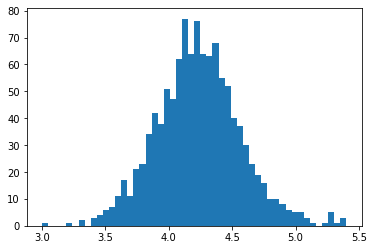

In [152]:
plt.hist(ave_word_lens, bins=50)
plt.show()

#### Average words per line

In [97]:
def ave_line_len(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    p_none = filter(None.__ne__, p)
    p = list(p_none)
    return np.mean(list(map(len, p)))

In [147]:
ave_line_lens = list(map(ave_line_len, raw_train_data['poetry_text'].values))

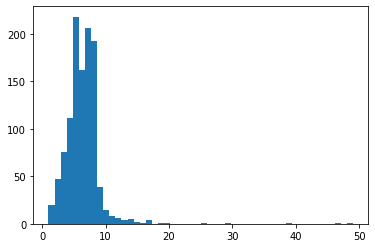

In [151]:
plt.hist(ave_line_lens, bins=50)
plt.show()

#### Average syllables per line

In [155]:
from nltk.tokenize import SyllableTokenizer

In [156]:
SSP = SyllableTokenizer()

In [171]:
def ave_syllables_line(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    p_none = filter(None.__ne__, p)
    p = list(p_none)
    num_syllables = []
    for line in p:
        syl_list = list(map(lambda x: SSP.tokenize(x), line))
        num_syllables.append(sum([len(x) for x in syl_list]))
    return np.mean(num_syllables)

In [175]:
ave_syllable_lens = list(map(ave_syllables_line, raw_train_data['poetry_text'].values))

/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: '’'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: '1'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: '2'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-pac

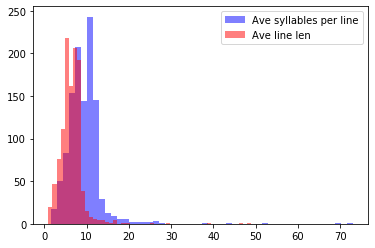

In [181]:
plt.hist(ave_syllable_lens, bins=50, color='b', alpha=0.5, label = 'Ave syllables per line')
plt.hist(ave_line_lens, bins=50, color='r', alpha = 0.5, label = 'Ave line len')
plt.legend()
plt.show()

#### Rhymes

For now, just record if there are any rhymes (i.e., binary)

In [177]:
import pronouncing

In [203]:
def has_rhyme(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    while [] in p:
        p.remove([])
    rhymes = 0
    last_rhyme = p[0][-1]
    for line in p:
        current_rhyme = line[-1]
        if last_rhyme != current_rhyme:
            if current_rhyme in pronouncing.rhymes(last_rhyme):
                rhymes = 1
        last_rhyme = current_rhyme
    return rhymes

In [204]:
rhymes = list(map(has_rhyme, raw_train_data['poetry_text'].values))

In [205]:
print("Number of non-rhyming poems: ", len(rhymes) - sum(rhymes), "Number of rhyming poems: ", sum(rhymes))

Number of non-rhyming poems:  663 Number of rhyming poems:  460


In [211]:
def num_rhymes(poem):
    lines = poem.split("\n")
    p = list(map(str_cleanup, lines))
    # get rid of none types
    while [] in p:
        p.remove([])
    rhymes = 0
    last_rhyme = p[0][-1]
    for line in p:
        current_rhyme = line[-1]
        if last_rhyme != current_rhyme:
            if current_rhyme in pronouncing.rhymes(last_rhyme):
                rhymes += 1
        last_rhyme = current_rhyme
    return rhymes

In [213]:
num_rhymes_poem = list(map(num_rhymes, raw_train_data['poetry_text'].values))

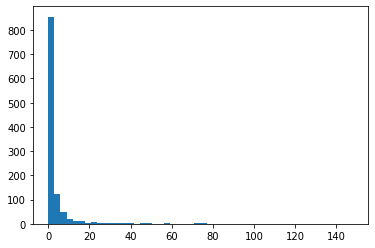

In [214]:
plt.hist(num_rhymes_poem, bins=50)
plt.show()

In [215]:
print(max(num_rhymes_poem))

148


### Adding features to data

In [217]:
train_data = raw_train_data
val_data = raw_val_data
test_data = raw_test_data

In [223]:
train_data['ave_word_len'] = ave_word_len
train_data['ave_line_len'] = ave_line_len
train_data['num_syllables'] = ave_syllable_lens
train_data['num_rhymes'] = num_rhymes_poem

In [224]:
val_data['ave_word_len'] = list(map(ave_word_len, raw_val_data['poetry_text'].values))
val_data['ave_line_len'] = list(map(ave_line_len, raw_val_data['poetry_text'].values))
val_data['num_syllables'] = list(map(ave_syllables_line, raw_val_data['poetry_text'].values))
val_data['num_rhymes'] = list(map(num_rhymes, raw_val_data['poetry_text'].values))

/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: '’'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: '—'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: '–'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-pac

In [225]:
test_data['ave_word_len'] = list(map(ave_word_len, raw_test_data['poetry_text'].values))
test_data['ave_line_len'] = list(map(ave_line_len, raw_test_data['poetry_text'].values))
test_data['num_syllables'] = list(map(ave_syllables_line, raw_test_data['poetry_text'].values))
test_data['num_rhymes'] = list(map(num_rhymes, raw_test_data['poetry_text'].values))

/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: 'œ'
  " assigning as vowel: '{}'".format(c)
/Users/aysjajohnson/.pyenv/versions/3.7.4/lib/python3.7/site-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: 'è'
  " assigning as vowel: '{}'".format(c)


In [227]:
train_data.to_csv(processed_root("04-bow-added-features/feat_train_data.csv"))
val_data.to_csv(processed_root("04-bow-added-features/feat_val_data.csv"))
test_data.to_csv(processed_root("04-bow-added-features/feat_test_data.csv"))